In [1]:
#Read in important paths 
import pandas as pd
import cPickle as cpk
import matplotlib as mpl
import sys
import numpy as np
sys.path.append("/Users/harrietalexander/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.11-py2.7.egg")
sys.path.insert(1, '/Users/harrietalexander/anaconda/lib/python2.7/site-packages')
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import gridspec
from itertools import combinations
import palettable.colorbrewer as b2m
import palettable as pal
import glob
from Bio import SeqIO
from string import ascii_lowercase, ascii_uppercase
from matplotlib.colors import LogNorm, NoNorm

mpl.rcParams['pdf.fonttype']=42
%matplotlib inline
def Calculate_Venn_comparison(hash):
    #input = a Hash of the form hash[Organism]=list of orthologus groups
    #Outputs a hash of the form key = all the variations of thes sets : list of orthologus genes in an inclusive way
    #It is inclusive so the set containing A uniq genes is going to contain all the genes for an org
    variations={}
    for i in range(len(hash)):
        for v in combinations(hash.keys(), i+1):
            vsets = [hash[x] for x in v]
            variations[tuple(sorted(v))]=reduce(lambda x,y: x.intersection(y), vsets)
    return variations

def GetDifference_Venn(variations):
    #Function takes the input from the above function and outputs a hash of the same format but 
    #each set is uniqe: e.g. there are no repeats of orthologus groups across sets. 
    outdict={}
    vkeys=variations.keys()
    #loop over each of the variable cases
    for v in variations:
        #create a set to do the comparisons
        vset=set(v)
        vdata_set=set(variations[v])
        #loop over all other variations
        for j in variations:
            #if v is a subset of jset we want to remove the items of jset from v set
            jdata_set=set(variations[j])
            jset=set(j)
            if vset.issubset(jset):
                if vset==jset:
                    pass
                else: 
                    newdata=vdata_set-jdata_set
                    vdata_set=newdata
        outdict[v]=vdata_set
    return outdict

ccmap=b2m.qualitative.Accent_8.get_mpl_colormap()


In [2]:
gFHash=cpk.load(open('../orthoMCL_output/Ehux_Dictionary.pickle', 'r'))
#load the GeneOrtholog:transcript hash
Hist_PD=pd.DataFrame(index=gFHash.keys(),columns=['NumGenes', 'Emi374', 'Emi379', 'Emi370', 'Emi219', 'Emihu1'])
Hist_PD=Hist_PD.fillna(0)
for i,key in enumerate(gFHash):
#     if i==100:
#         break
    l=len(gFHash[key])
    Hist_PD.loc[key, 'NumGenes']=l
    for transcript in gFHash[key]:
        org=transcript.split('|')[0]
        Hist_PD.loc[key,org]+=1


In [3]:
GenesInOrg={}
GenesInOrg['Emi219']=Hist_PD[Hist_PD.Emi219>0].index
GenesInOrg['Emi379']=Hist_PD[Hist_PD.Emi379>0].index
GenesInOrg['Emi370']=Hist_PD[Hist_PD.Emi370>0].index
GenesInOrg['Emi374']=Hist_PD[Hist_PD.Emi374>0].index
GenesInOrg['Emihu1']=Hist_PD[Hist_PD.Emihu1>0].index


Genes_In_Each_Cat=Calculate_Venn_comparison(GenesInOrg)
Genes_Uniq_Venn=GetDifference_Venn(Genes_In_Each_Cat)
CoreGenes=Genes_Uniq_Venn[('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')] #get the genes that are core to all organisms


#KEGG Orthology

In [4]:
KAAS_Hash={}
for line in open('KAAS_Ehux_Protein_Annotation.tab', 'r'):
    line=line.split()
    if len(line)>1:
        KAAS_Hash[line[0].strip()]=line[1].strip()
    else:
        KAAS_Hash[line[0].strip()]=None
# KAAS_Hashcpk.load(open('Kegg_Hash.pickle', 'r'))

In [5]:
newOG_KEGGHash={}
for gene in gFHash:
    newOG_KEGGHash[gene]=[]
    for transcript in gFHash[gene]:
        kegg=KAAS_Hash[transcript]
        if kegg in newOG_KEGGHash[gene]:
            pass
        elif kegg==None:
            pass
        else: 
            newOG_KEGGHash[gene].append(kegg)#


In [8]:
# #check for instances where an orthologus group has >1 annotation from KEGG. 
# c=0
# for k in newOG_KEGGHash:
#     if len(newOG_KEGGHash[k])>1:
#         c+=1
#         print newOG_KEGGHash[k]

In [6]:
#Read in ko00002 table
Kegg_masterDict_ko0002={}
file=open('ko00002_table.tab', 'r')
header=next(file)
header= header.split('\t')
for l in file:
    line=l.split('\t')
    kegg=line[0]
    a={}
    for i,e in enumerate(line):
        a[header[i]]=e
    Kegg_masterDict_ko0002[kegg]=a


##Look at the composition of the original transcriptomes (no TPM)

In [7]:
# #Calculate the number of genes per submodule/that are unannoated across the different sets.  The sum of which will equal to the toatl 
# translated={}
# for i,key in enumerate(Genes_Uniq_Venn.keys()):
#     translated[key]=str(key)
# #Get the keys for the dictionary.     
# xs=translated.values()
# xs.sort()
# xs.sort(key = lambda s: len(s), reverse=True)
# xs
# for k in Kegg_masterDict_ko0002:
#     s.add(Kegg_masterDict_ko0002[k]['Submodule1'])
# s.add('Unannotated')


# Kegg_DF_CoreGenes=pd.DataFrame(index=s, columns=xs)
# Kegg_DF_CoreGenes=Kegg_DF_CoreGenes.fillna(0)
# for setType in Genes_Uniq_Venn:
#     a_setType=translated[setType]
#     for OG in Genes_Uniq_Venn[setType]:
#         num=len(newOG_KEGGHash[OG])
#         totalTPM_OG=test.loc[OG,'TPM']/num
#         if newOG_KEGGHash[OG]==[]:
#             p='Unannotated'
#             Kegg_DF_CoreGenes.loc[p,a_setType]+=1
#         else:
#             for k in newOG_KEGGHash[OG]:
#                 if k in Kegg_masterDict_ko0002.keys():
#                     p=Kegg_masterDict_ko0002[k]['Submodule1']
#                     Kegg_DF_CoreGenes.loc[p,a_setType]+=1.0/num
#                 else:
#                     p='Unannotated'
#                     Kegg_DF_CoreGenes.loc[p,a_setType]+=1.0/num
# Kegg_DF_CoreGenes_Percentage=(Kegg_DF_CoreGenes.drop('Unannotated')/Kegg_DF_CoreGenes.drop('Unannotated').sum())
# Kegg_DF_CoreGenes.to_csv('Total_Venn_KEGGTranscripts_BySpecies.tab', sep='\t')
# Kegg_DF_CoreGenes_Percentage.to_csv('Total_Venn_Percent_KeggModule.tab', sep='\t')
Kegg_DF_CoreGenes=pd.read_csv('Total_Venn_KEGGTranscripts_BySpecies.tab', sep='\t', index_col=0)
Kegg_DF_CoreGenes_Percentage=pd.read_csv('Total_Venn_Percent_KeggModule.tab', sep='\t', index_col=0)
Ehux_Composite=Kegg_DF_CoreGenes.sum(axis=1)

## Total number of transcripts

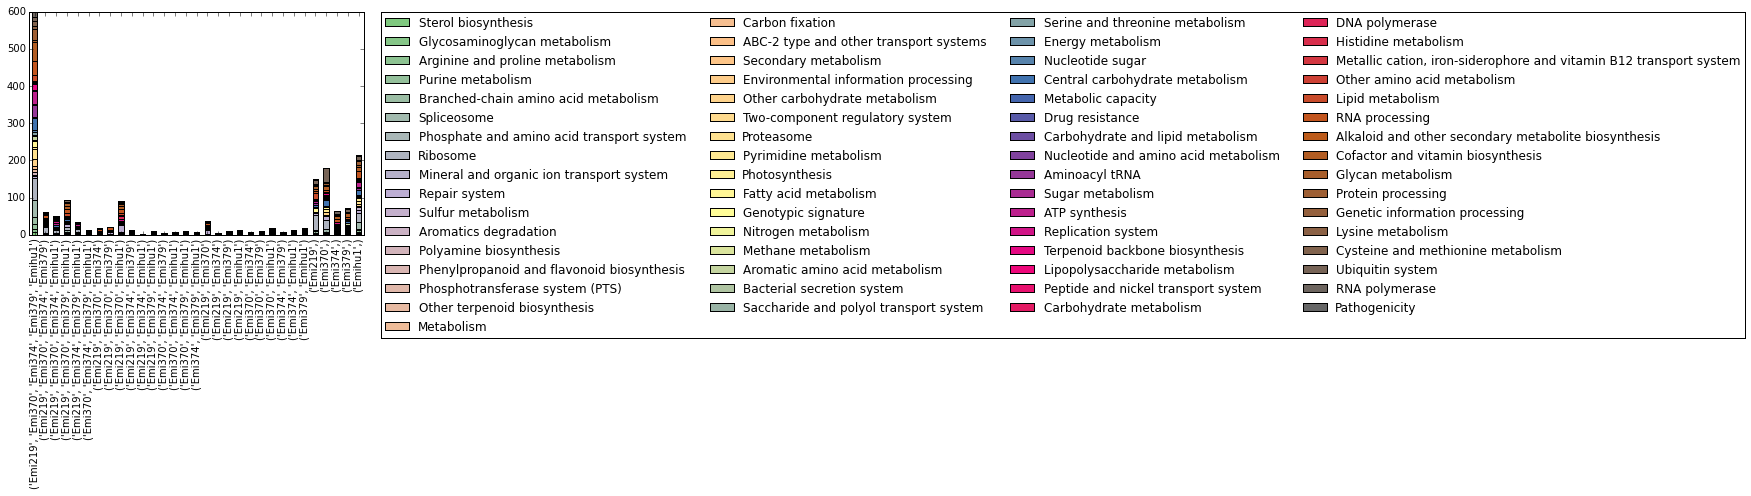

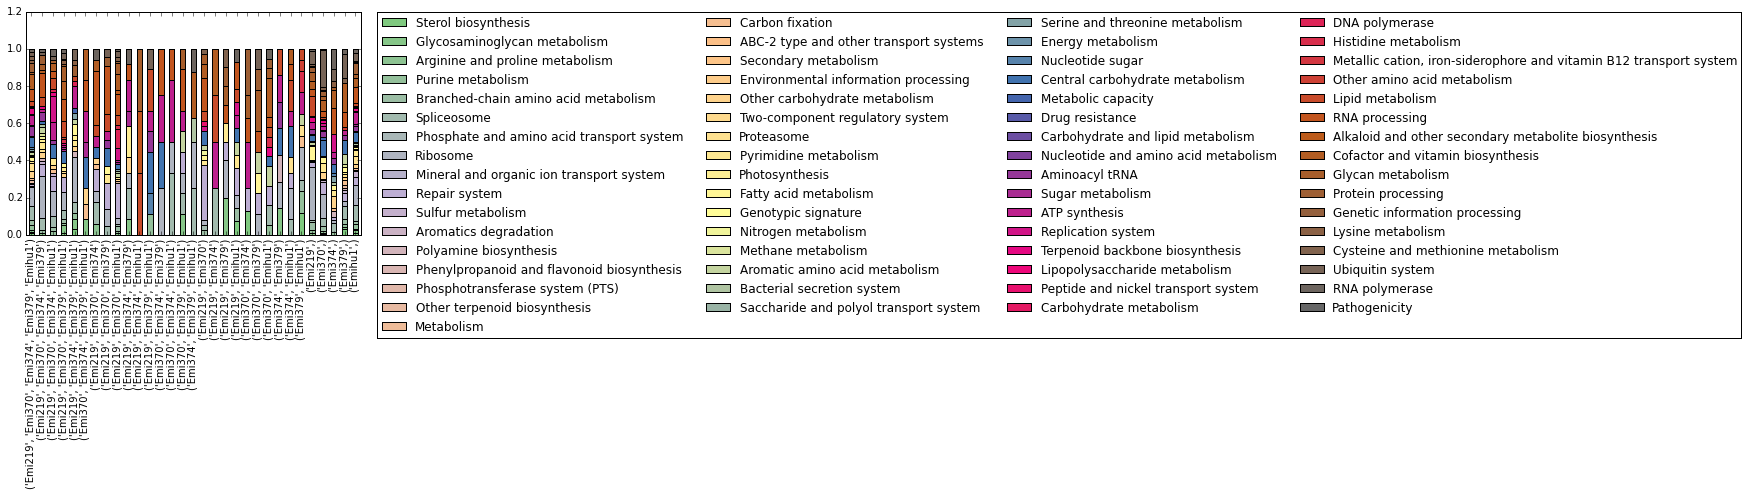

In [11]:
#Do some bar plots to look at the overall 
TotalNum_bar=Kegg_DF_CoreGenes.drop('Unannotated').T.plot(kind='bar', stacked=True, colormap=ccmap, grid=False)
TotalNum_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)
TotalNum_bar.yaxis.set_label('Number of transcripts')
TotalNum_bar.figure.savefig('Total_BarPlot.pdf')

PercentNum_bar=Kegg_DF_CoreGenes_Percentage.T.plot(kind='bar', stacked=True, legend=False, colormap=ccmap, grid=False)
PercentNum_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)
PercentNum_bar.yaxis.set_label('% transcripts')
PercentNum_bar.figure.savefig('PercentNumber_BarPlot.pdf')

PercentNum_bar

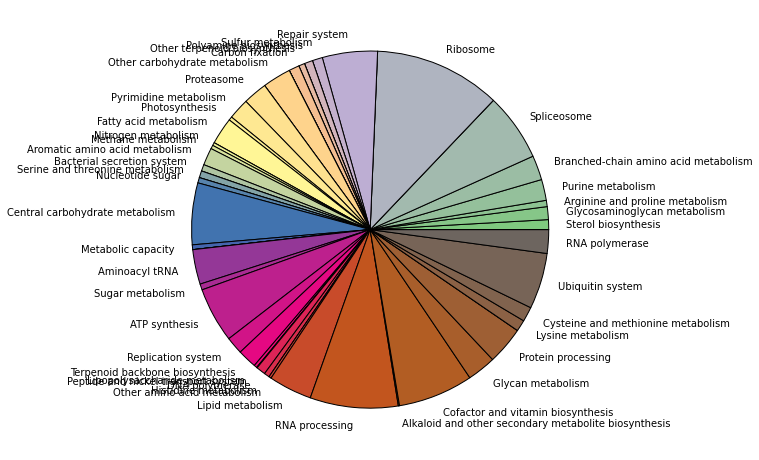

In [12]:
Ehux_CompositePie=Ehux_Composite.drop('Unannotated').plot(kind='pie', cmap=ccmap, figsize=(8,8))
Ehux_CompositePie.set_aspect('equal')
Ehux_CompositePie.figure.savefig('Ehux_CompositePie.pdf')

In [255]:
Ehux_Composite.drop('Unannotated').sum()

1846.3333333333333

In [13]:
def ParseField_RSEM_Files(files):
    InsituHash={}
    for f in glob.glob(files):
        name=f.split('/')[2]
        name=name.split('_')[0]
        
        InsituHash[name]=pd.read_table(f,index_col='gene_id')

    outHash={}
    for sample in InsituHash:
        a={}
        for group in Genes_Uniq_Venn:
            match=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM
            summedTPM=InsituHash[sample].loc[Genes_Uniq_Venn[group]].TPM.sum()
            len_match=len(match)
            len_match_greater0=len(match[match>0])
            a[group]={}
            a[group]['TPM']=summedTPM
            a[group]['Len_total']=len_match
            a[group]['Greater0']=len_match_greater0
        outHash[sample]=a
    return InsituHash
        

In [9]:
# TPM_Hash=ParseField_RSEM_Files('../output_RSEM_Bowtie2/*genes.results')


# #Loop over each of the files and create the panda dictionary then sum the treatments
# def Create_Hash_KeggFiles(fileHash):
#     outHash={}
#     translated={}
#     for i,key in enumerate(Genes_Uniq_Venn.keys()):
#         abc=ascii_lowercase+ascii_uppercase
#         translated[key]=str(key)

#     xs=translated.values()
#     xs.sort()
#     xs.sort(key = lambda s: len(s), reverse=True)
#     xs
#     s=set()
#     for k in Kegg_masterDict_ko0002:
#         s.add(Kegg_masterDict_ko0002[k]['Submodule1'])
#     s.add('Unannotated')

#     for sample in TPM_Hash:
#         Sample_TPM=TPM_Hash[sample]
#         Kegg_DF_CoreGenes=pd.DataFrame(index=s, columns=xs)
#         Kegg_DF_CoreGenes=Kegg_DF_CoreGenes.fillna(0)
#         for setType in Genes_Uniq_Venn:
#             a_setType=translated[setType]
#             for OG in Genes_Uniq_Venn[setType]:
#                 totalTPM_OG=Sample_TPM.loc[OG,'TPM']
#                 if newOG_KEGGHash[OG]==[]:
#                     p='Unannotated'
#                     Kegg_DF_CoreGenes.loc[p,a_setType]+=totalTPM_OG
#                 else:
#                     num=len(newOG_KEGGHash[OG])
#                     for k in newOG_KEGGHash[OG]:
#                         if k in Kegg_masterDict_ko0002.keys():
#                             p=Kegg_masterDict_ko0002[k]['Submodule1']
#                             Kegg_DF_CoreGenes.loc[p,a_setType]+=totalTPM_OG/num
#         Kegg_DF_CoreGenes_Percentage=(Kegg_DF_CoreGenes.drop('Unannotated')/Kegg_DF_CoreGenes.drop('Unannotated').sum())
#         outHash[sample+'_percentage']=Kegg_DF_CoreGenes_Percentage
#         outHash[sample+'_raw']=Kegg_DF_CoreGenes
#         Kegg_DF_CoreGenes.to_csv(sample+'_KeggModule_rawTPM.tab', sep='\t')
#         Kegg_DF_CoreGenes_Percentage.to_csv(sample+'_KeggModule_percentage.tab', sep='\t')
#     return outHash
        
# KEGG_TPM_Hash=Create_Hash_KeggFiles(TPM_Hash)

# cpk.dump(KEGG_TPM_Hash, open('KEGG_TPM_Hash.pickle', 'w'))

## The above script can be used to generate the pickle and the original files/pickle.  But, it takes a long time to run... so just load it if you can

KEGG_TPM_Hash=cpk.load(open('KEGG_TPM_Hash.pickle', 'r'))


## Total TPM Mapping 

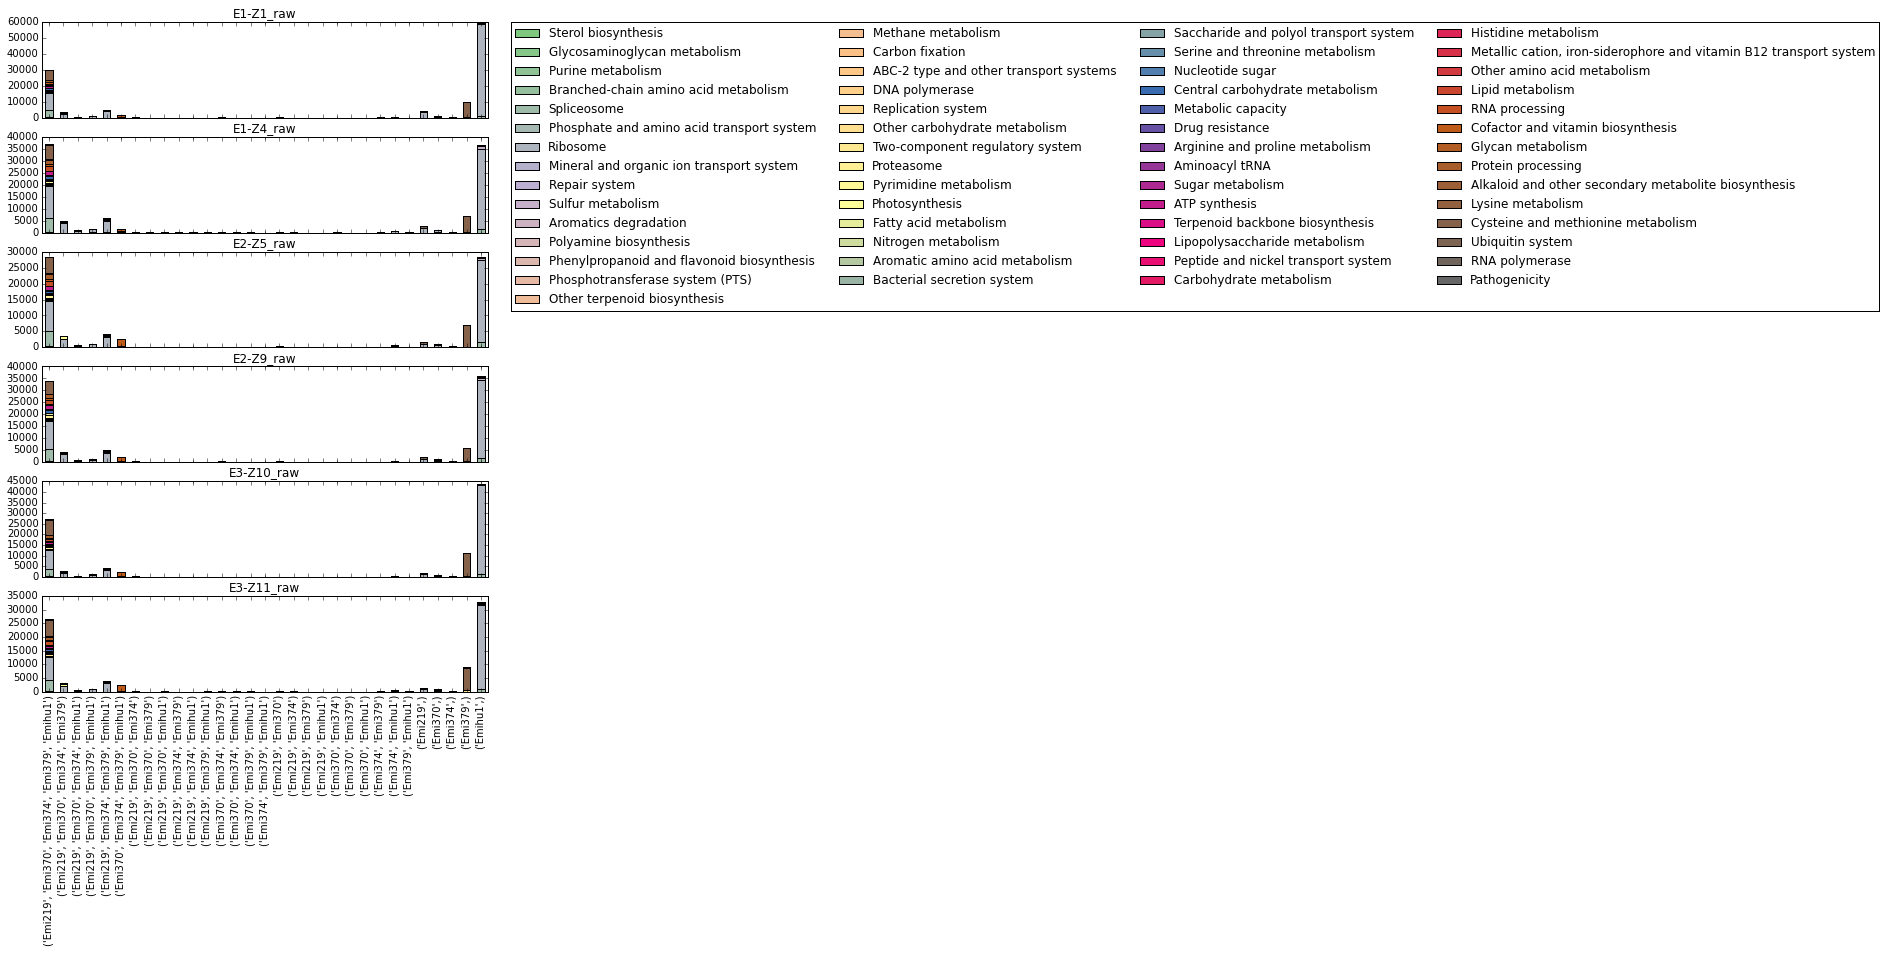

In [250]:
keys=KEGG_TPM_Hash.keys()
rawKeys = [s for s in keys if "raw" in s]
InsituKeys = [s for s in rawKeys if "Z" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KEGG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax, grid=False)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KEGG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Raw_Insitu.pdf')

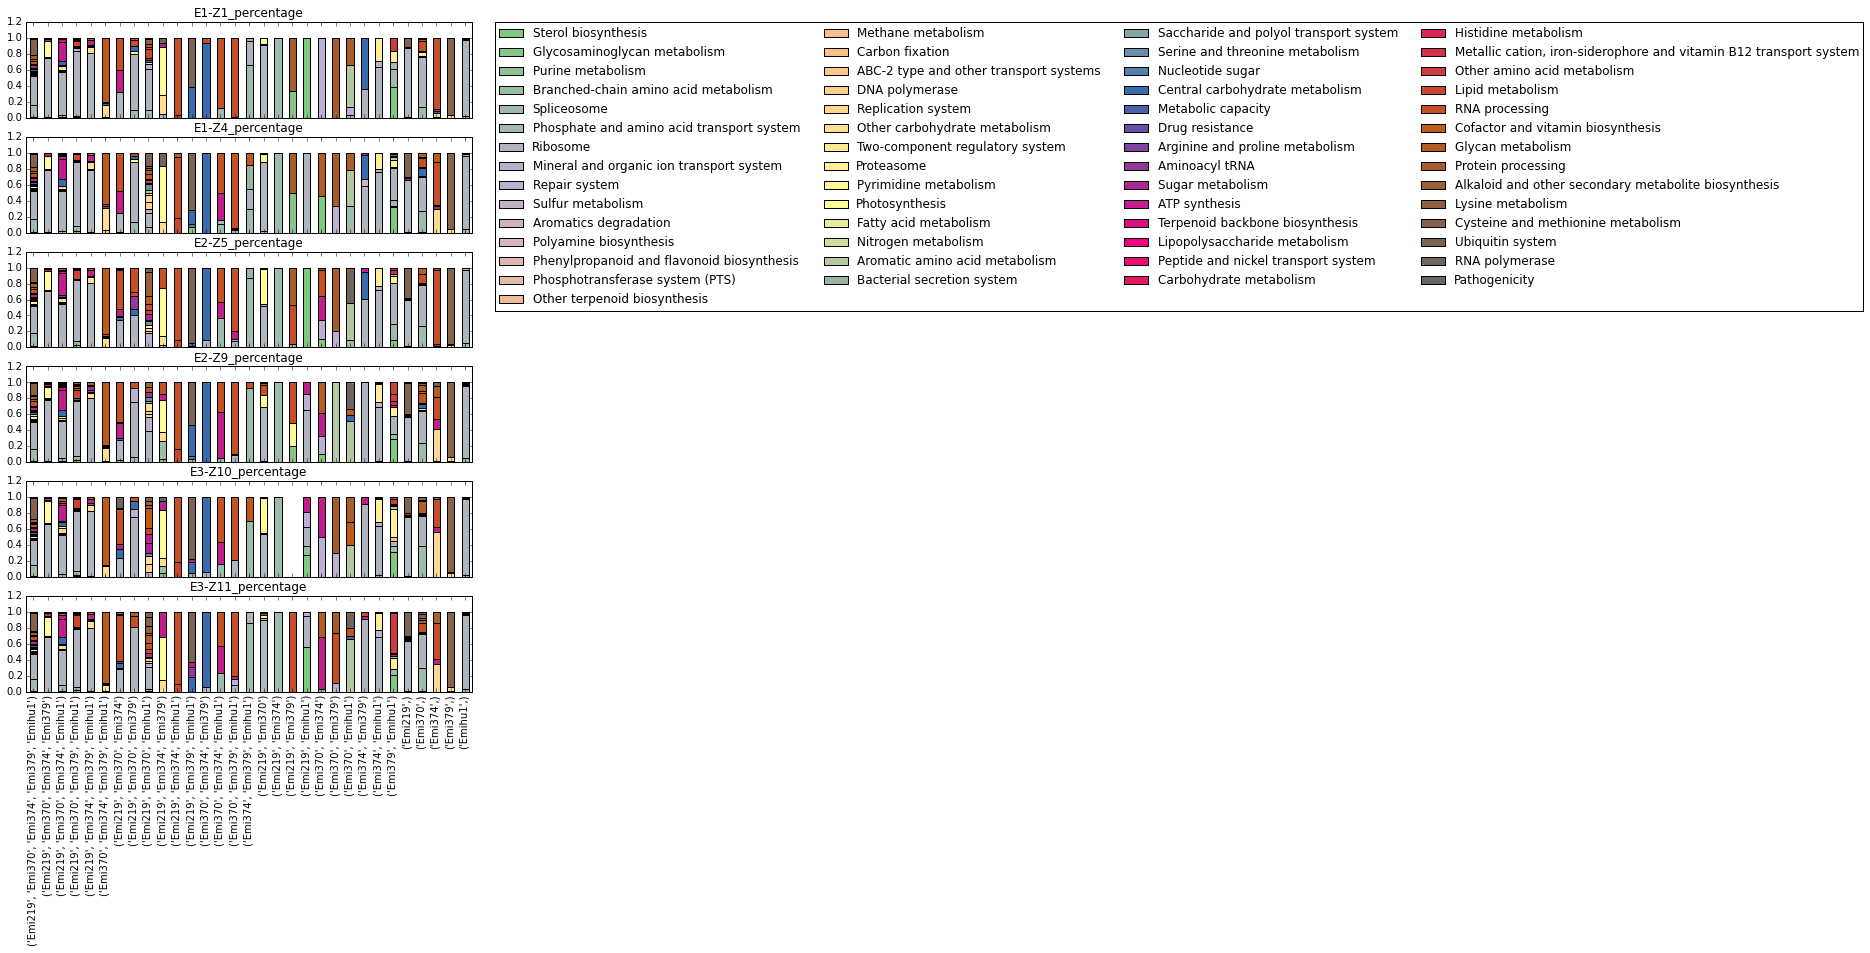

In [60]:
keys=KEGG_TPM_Hash.keys()
rawKeys = [s for s in keys if "percentage" in s]
InsituKeys = [s for s in rawKeys if "Z" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KEGG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, grid=False, title=keys,ax=ax)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KEGG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax, grid=False, legend=False)
fig.savefig('Percentage_Insitu.pdf')

ERROR! Session/line number was not unique in database. History logging moved to new session 202


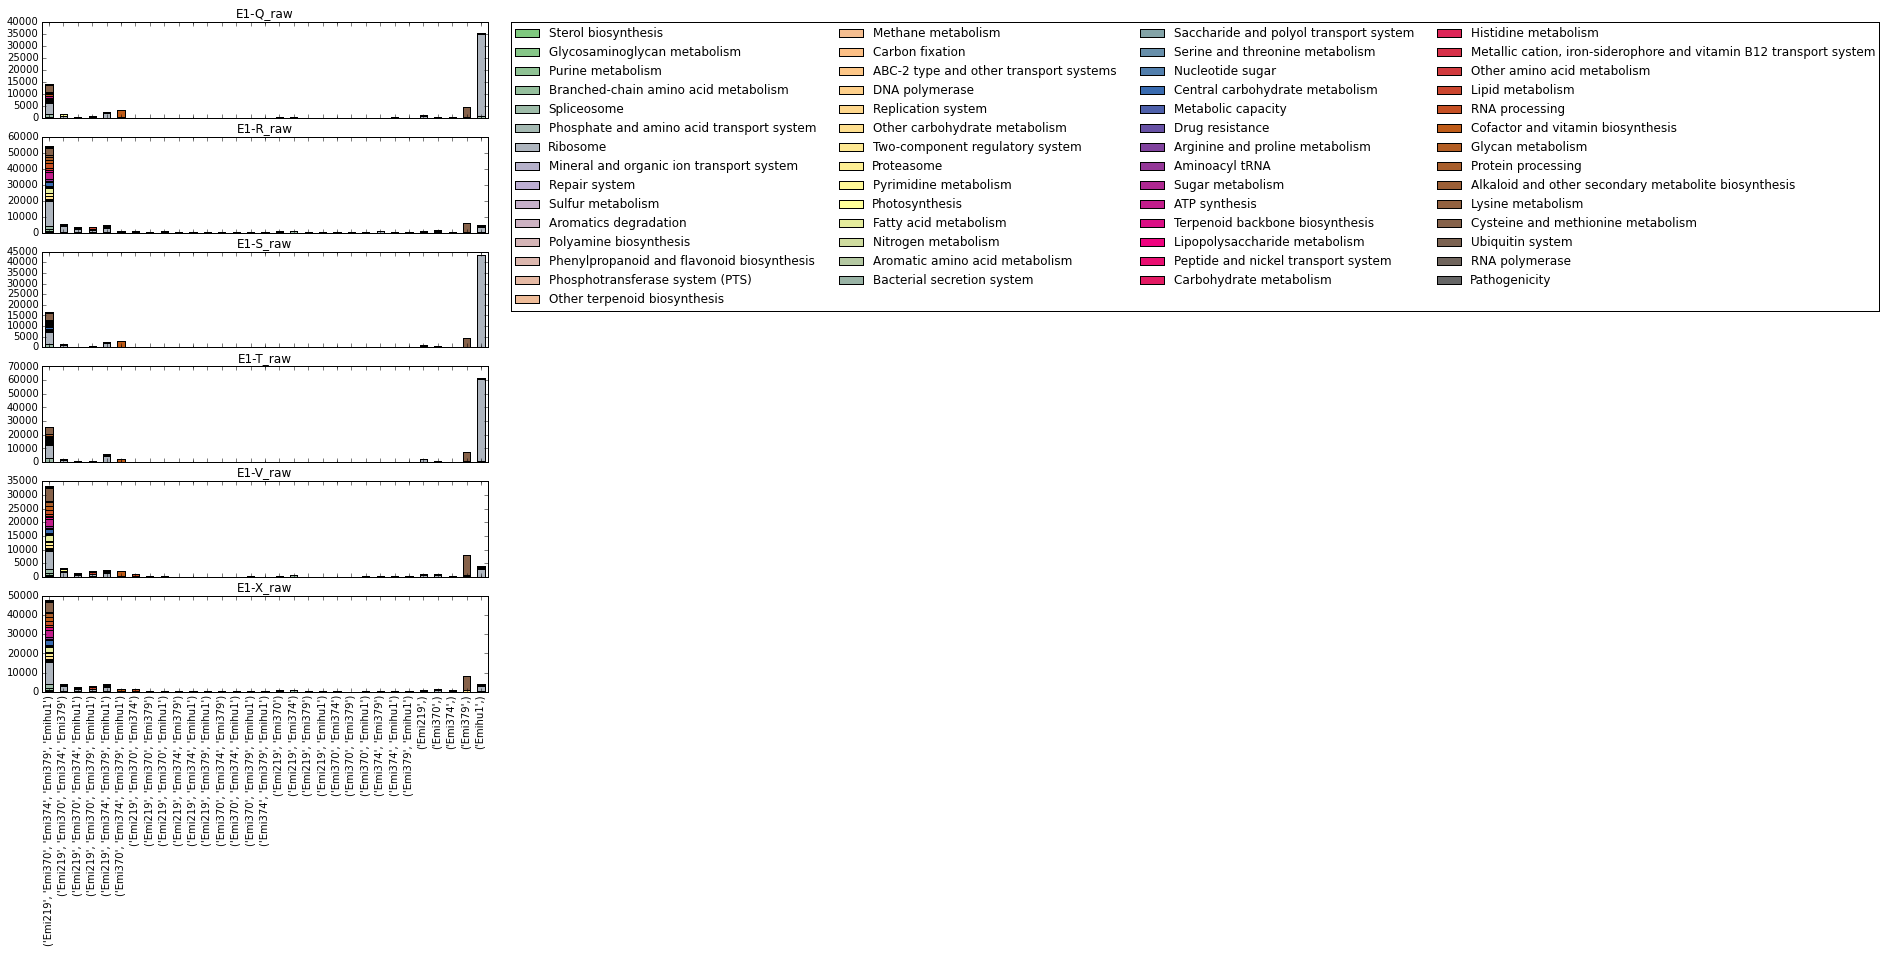

In [54]:
keys=KEGG_TPM_Hash.keys()
rawKeys = [s for s in keys if "raw" in s]
InsituKeys = [s for s in rawKeys if "1" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KEGG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, grid=False, title=keys,ax=ax)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KEGG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Raw_E1.pdf')

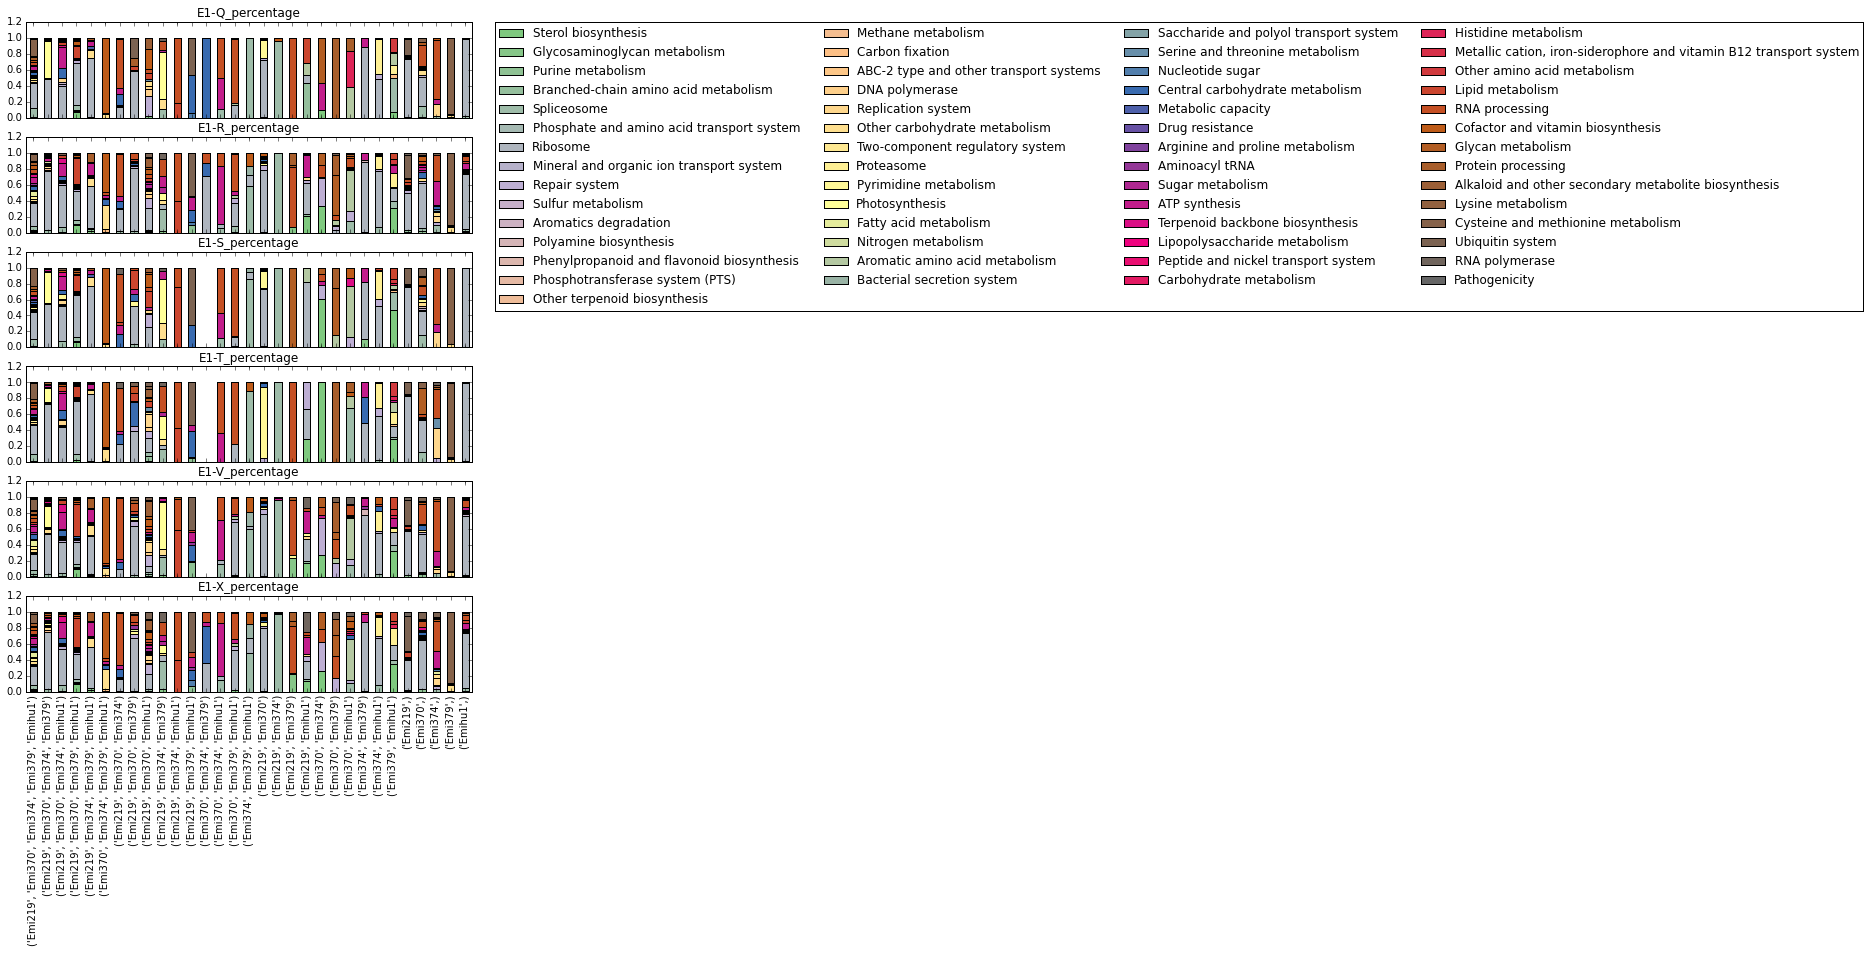

In [59]:
keys=KEGG_TPM_Hash.keys()
rawKeys = [s for s in keys if "percentage" in s]
InsituKeys = [s for s in rawKeys if "1" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KEGG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, grid=False, title=keys,ax=ax)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KEGG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Percentage_E1.pdf')

/Users/harrietalexander/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


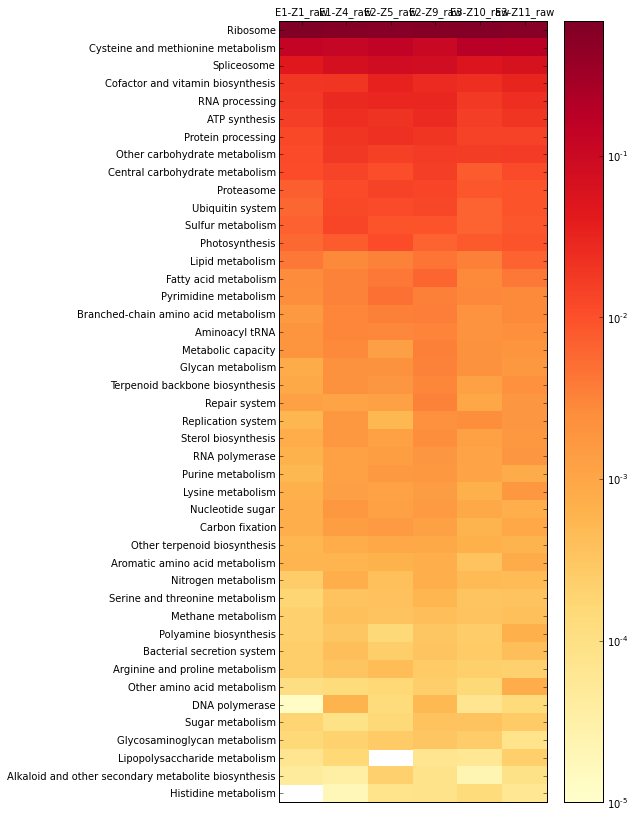

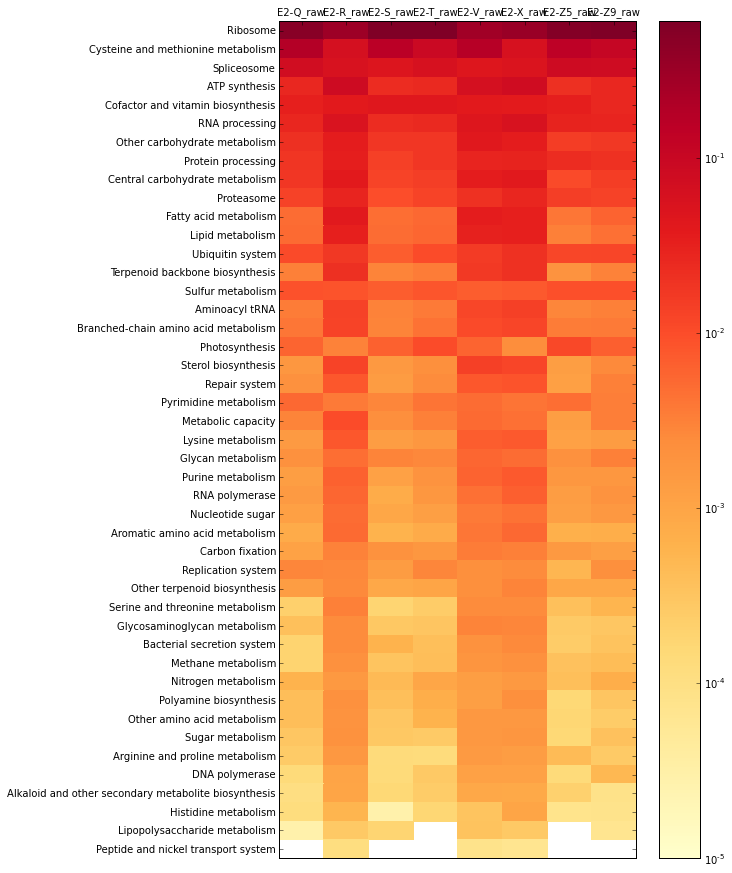

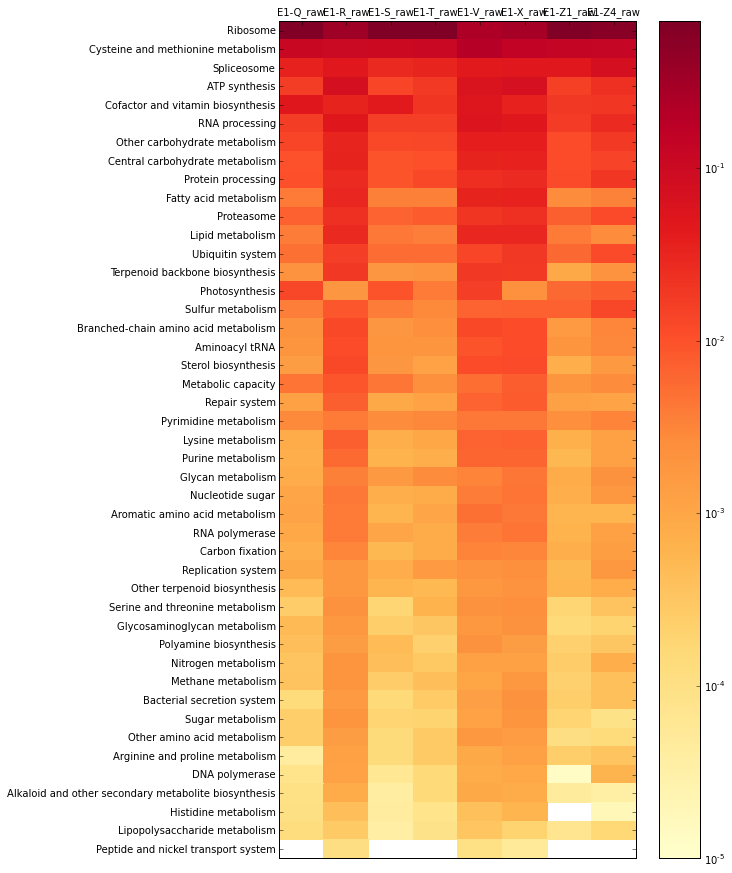

In [206]:
keys=KEGG_TPM_Hash.keys()

rawKeys = [s for s in keys if "raw" in s]
rawKeys=sorted(rawKeys)
Ehux_Summed_TPM=pd.DataFrame(columns=rawKeys, index=KEGG_TPM_Hash['E1-Q_raw'].index)

for key in rawKeys:
    v=KEGG_TPM_Hash[key].sum(axis=1)
    Ehux_Summed_TPM[key]=v

Ehux_Summed_TPM=Ehux_Summed_TPM.drop(['Unannotated'])
Ehux_Summed_Percentage=Ehux_Summed_TPM/Ehux_Summed_TPM.sum()

def HeatMap(All_insitu_Percent, columns=None,colormap=b2m.sequential.YlOrRd_9.get_mpl_colormap(), m=1e-5):
    if columns:
        All_insitu_Percent=All_insitu_Percent[columns]
    # sckos=['SS1','SS2','SS3', 'SS4', 'SS5']
    All_insitu_Percent['mean']=All_insitu_Percent.mean(skipna=1, axis=1) #calculate mean value for each class

    All_insitu_Percent=All_insitu_Percent.sort(columns='mean', ascending=False)#Sort by the mean value

    All_insitu_Percent=All_insitu_Percent.drop('mean',1) #drop mean column
    All_insitu_Percent=All_insitu_Percent.loc[All_insitu_Percent.sum(axis=1)!=0]

    col_labels=list(All_insitu_Percent.index)
    row_labels=list(All_insitu_Percent.columns.values)
    fig3,ax3=plt.subplots()
    fig3.set_figheight(len(col_labels)/3)
    fig3.set_figwidth(len(row_labels))
    heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=colormap, norm=LogNorm(vmin=m, vmax=All_insitu_Percent.max().max()))
    #heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=plt.cm.jet, vmin=0, vmax=.25)
    ax3.set_xticks(np.arange(All_insitu_Percent.shape[1])+0.5, minor=False)
    ax3.set_yticks(np.arange(All_insitu_Percent.shape[0])+0.5, minor=False)
    ax3.invert_yaxis()
    ax3.xaxis.tick_top()
    ax3.margins(0,0)

    ax3.set_xticklabels(row_labels, minor=False)
    ax3.set_yticklabels(col_labels, minor=False)
    plt.colorbar(heatmap3)
    plt.show()
    return fig3

rawKeys = [s for s in keys if "raw" in s]
insituKeys = [s for s in rawKeys if "Z" in s]
insituKeys=sorted(insituKeys)
EKeys = [s for s in rawKeys if "E2" in s]
EKeys=sorted(EKeys)
E1Keys = [s for s in rawKeys if "E1" in s]
E1Keys=sorted(E1Keys)

Insitu_HeatMap=HeatMap(Ehux_Summed_Percentage, columns=insituKeys)
E2_Heatmap=HeatMap(Ehux_Summed_Percentage, columns=EKeys)
E1_Heatmap=HeatMap(Ehux_Summed_Percentage, columns=E1Keys)
Insitu_HeatMap.savefig('Insitu_KEGG_Heatmap.pdf')
E1_Heatmap.savefig('E1_Heatmap_KEGG.pdf')
E2_Heatmap.savefig('E2_Heatmap_KEGG.pdf')

/Users/harrietalexander/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


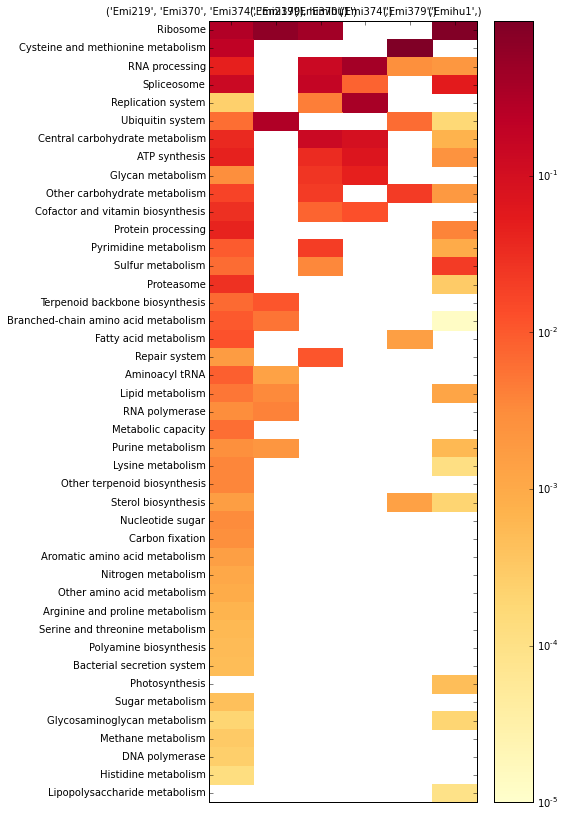

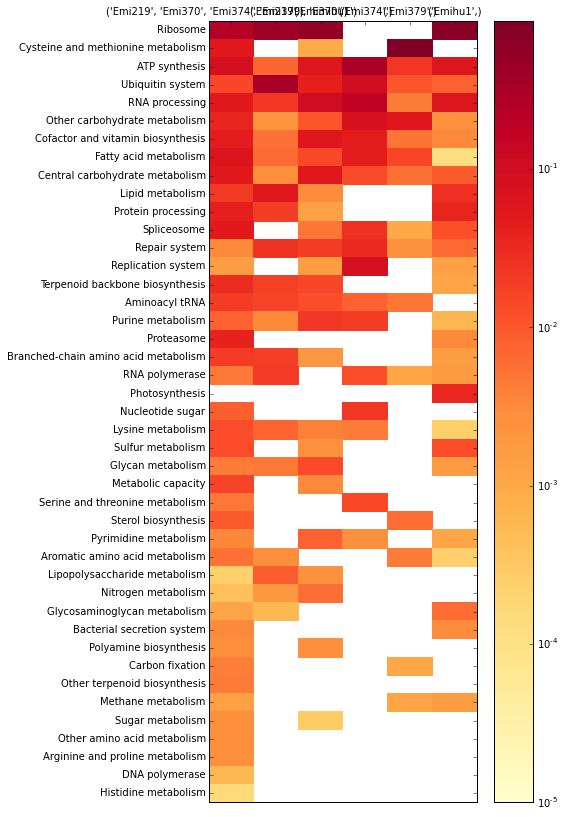

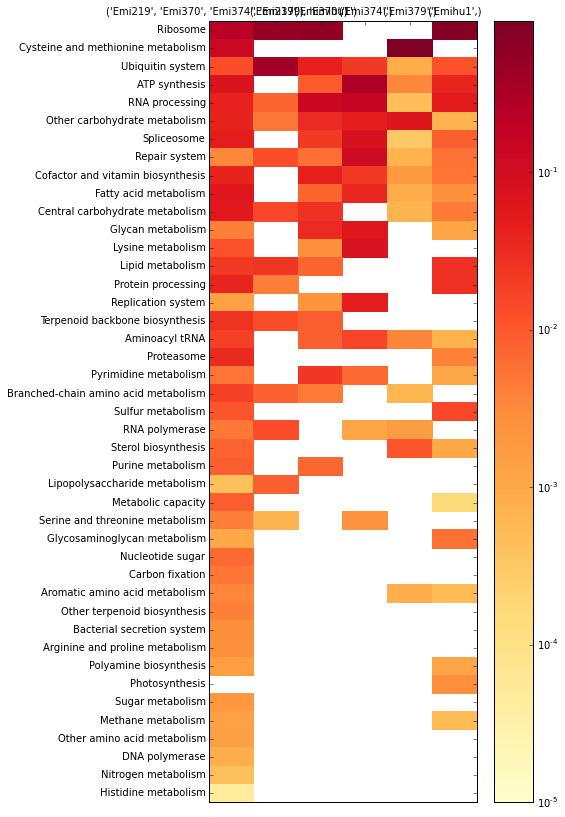

In [204]:
cols=KEGG_TPM_Hash['E1-Q_percentage'].columns
a=[s for s in cols if (len(s)==11)|(len(s)==50)]
h=HeatMap(KEGG_TPM_Hash['E2-Q_percentage'], a)
h=HeatMap(KEGG_TPM_Hash['E2-R_percentage'], a)
h=HeatMap(KEGG_TPM_Hash['E2-V_percentage'], a)

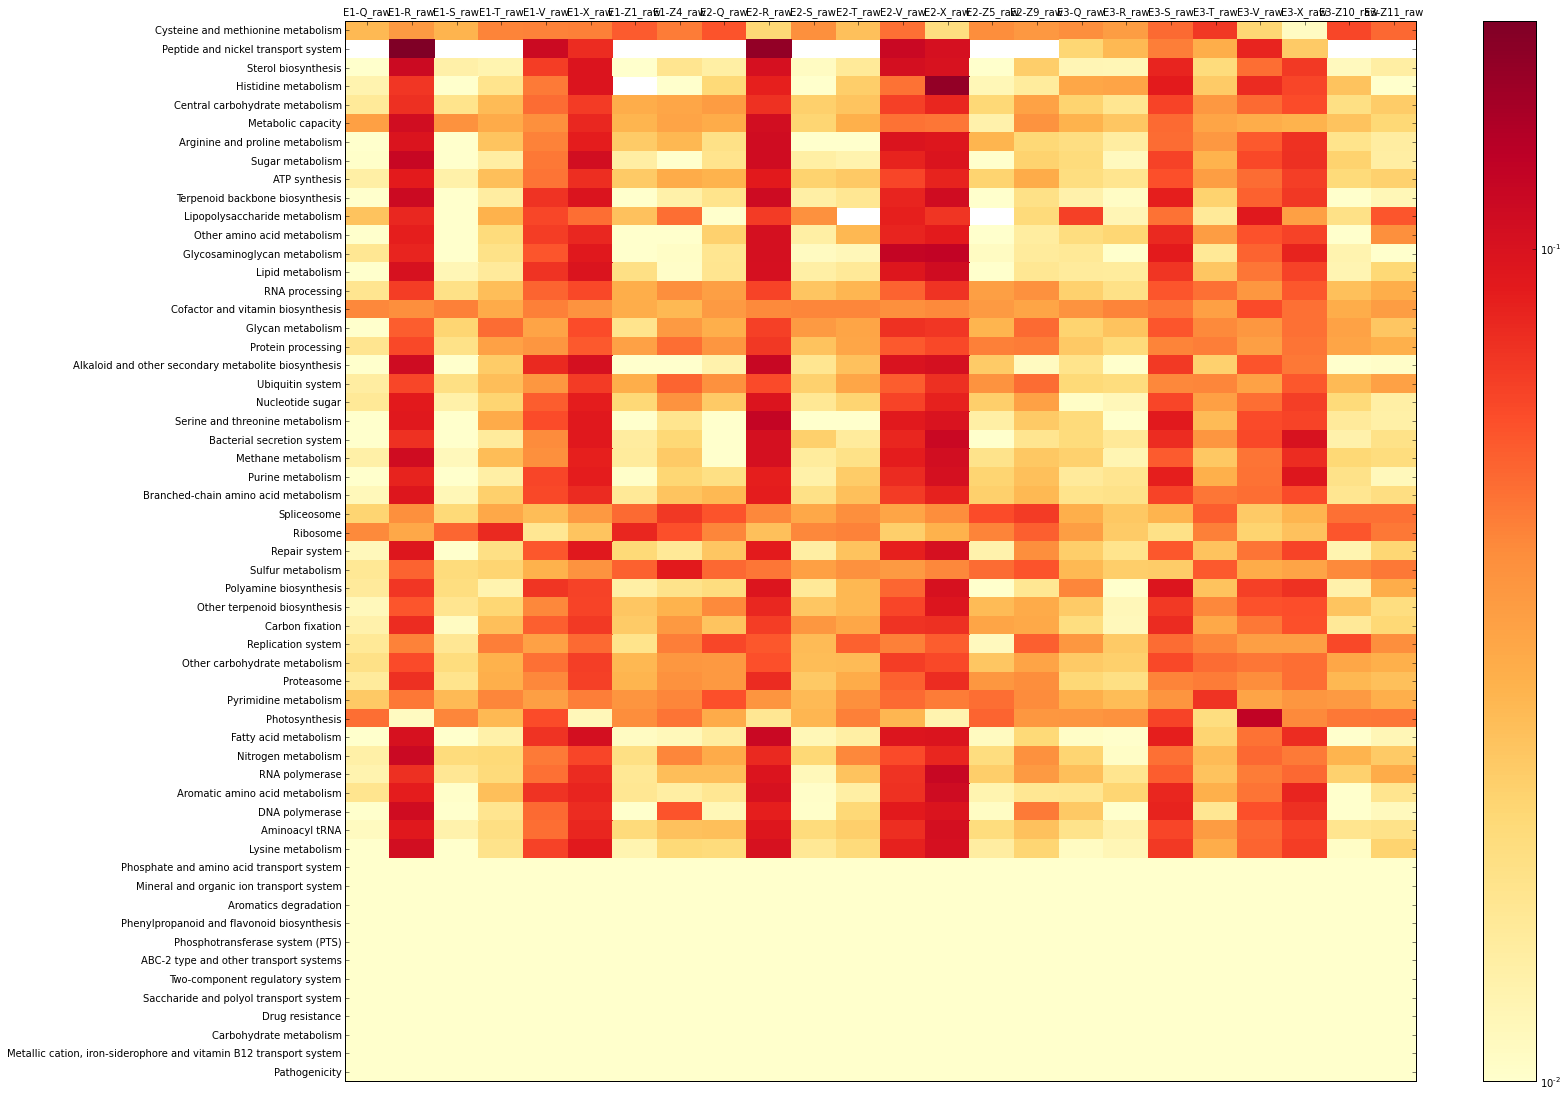

In [256]:

Ehux_Summed_Percentage_summed=Ehux_Summed_TPM.T/Ehux_Summed_TPM.sum(axis=1)
Ehux_Summed_TPM
h=HeatMap(Ehux_Summed_Percentage_summed.T, m=1e-2)

#KOG Orthology


In [10]:
#Read in KOG table
KOG_MasterDict={}
file=open('KOG/output/output.2', 'r')
header=next(file)
header= header.split('\t')
for l in file:
    line=l.split('\t')
    PID=line[0]
    a={}
    for i,e in enumerate(line):
        a[header[i].strip()]=e.strip()
    KOG_MasterDict[PID]=a


In [11]:
newOG_KOGHash={}
for gene in gFHash:
    newOG_KOGHash[gene]=[]
    for transcript in gFHash[gene]:
        if transcript in KOG_MasterDict:
            KOG=KOG_MasterDict[transcript]['class description']
            if KOG in newOG_KOGHash[gene]:
                pass
            else: 
                newOG_KOGHash[gene].append(KOG)
KOG_cts={}                
    

In [12]:
# TPM_Hash=ParseField_RSEM_Files('../output_RSEM_Bowtie2/*genes.results')

# def Create_Hash_KogFiles(fileHash):
#     translated={}
#     for i,key in enumerate(Genes_Uniq_Venn.keys()):
#         translated[key]=str(key)

#     xs=translated.values()
#     xs.sort()
#     xs.sort(key = lambda s: len(s), reverse=True)
#     xs
#     s=set()
#     for line in open('KOG/output/output.2.class'):
#         l=line.split('\t')
#         s.add(l[2].strip())
#     s.add('Unannotated')
#     s.remove('description')
#     s.add('Multiple classes')
             
#     for sample in TPM_Hash:
#         Sample_TPM=TPM_Hash[sample]
#         Kegg_DF_CoreGenes=pd.DataFrame(index=s, columns=xs)
#         Kegg_DF_CoreGenes=Kegg_DF_CoreGenes.fillna(0)
#         for setType in Genes_Uniq_Venn:
#             a_setType=translated[setType]
#             for OG in Genes_Uniq_Venn[setType]:
#                 totalTPM_OG=Sample_TPM.loc[OG,'TPM']
#                 if newOG_KOGHash[OG]==[]:
#                     p='Unannotated'
#                     Kegg_DF_CoreGenes.loc[p,a_setType]+=totalTPM_OG
#                 else:
#                     num=len(newOG_KOGHash[OG])
#                     for k in newOG_KOGHash[OG]:
#                         p=k
#                         Kegg_DF_CoreGenes.loc[p,a_setType]+=totalTPM_OG/num
#         Kegg_DF_CoreGenes_Percentage=(Kegg_DF_CoreGenes.drop('Unannotated')/Kegg_DF_CoreGenes.drop('Unannotated').sum())
#         outHash[sample+'_percentage']=Kegg_DF_CoreGenes_Percentage
#         outHash[sample+'_raw']=Kegg_DF_CoreGenes
#         Kegg_DF_CoreGenes.to_csv(sample+'_KOGModule_rawTPM.tab', sep='\t')
#         Kegg_DF_CoreGenes_Percentage.to_csv(sample+'_KOGModule_percentage.tab', sep='\t')
#     return outHash
        
# KOG_TPM_Hash=Create_Hash_KogFiles(TPM_Hash)
# cpk.dump(KOG_TPM_Hash, open('KOG_TPM_Hash.pickle', 'w'))

##The above script can be used to generate the pickle and the original files/pickle.  But, it takes a long time to run... so just load it if you can

KOG_TPM_Hash=cpk.load(open('KOG_TPM_Hash.pickle', 'r'))

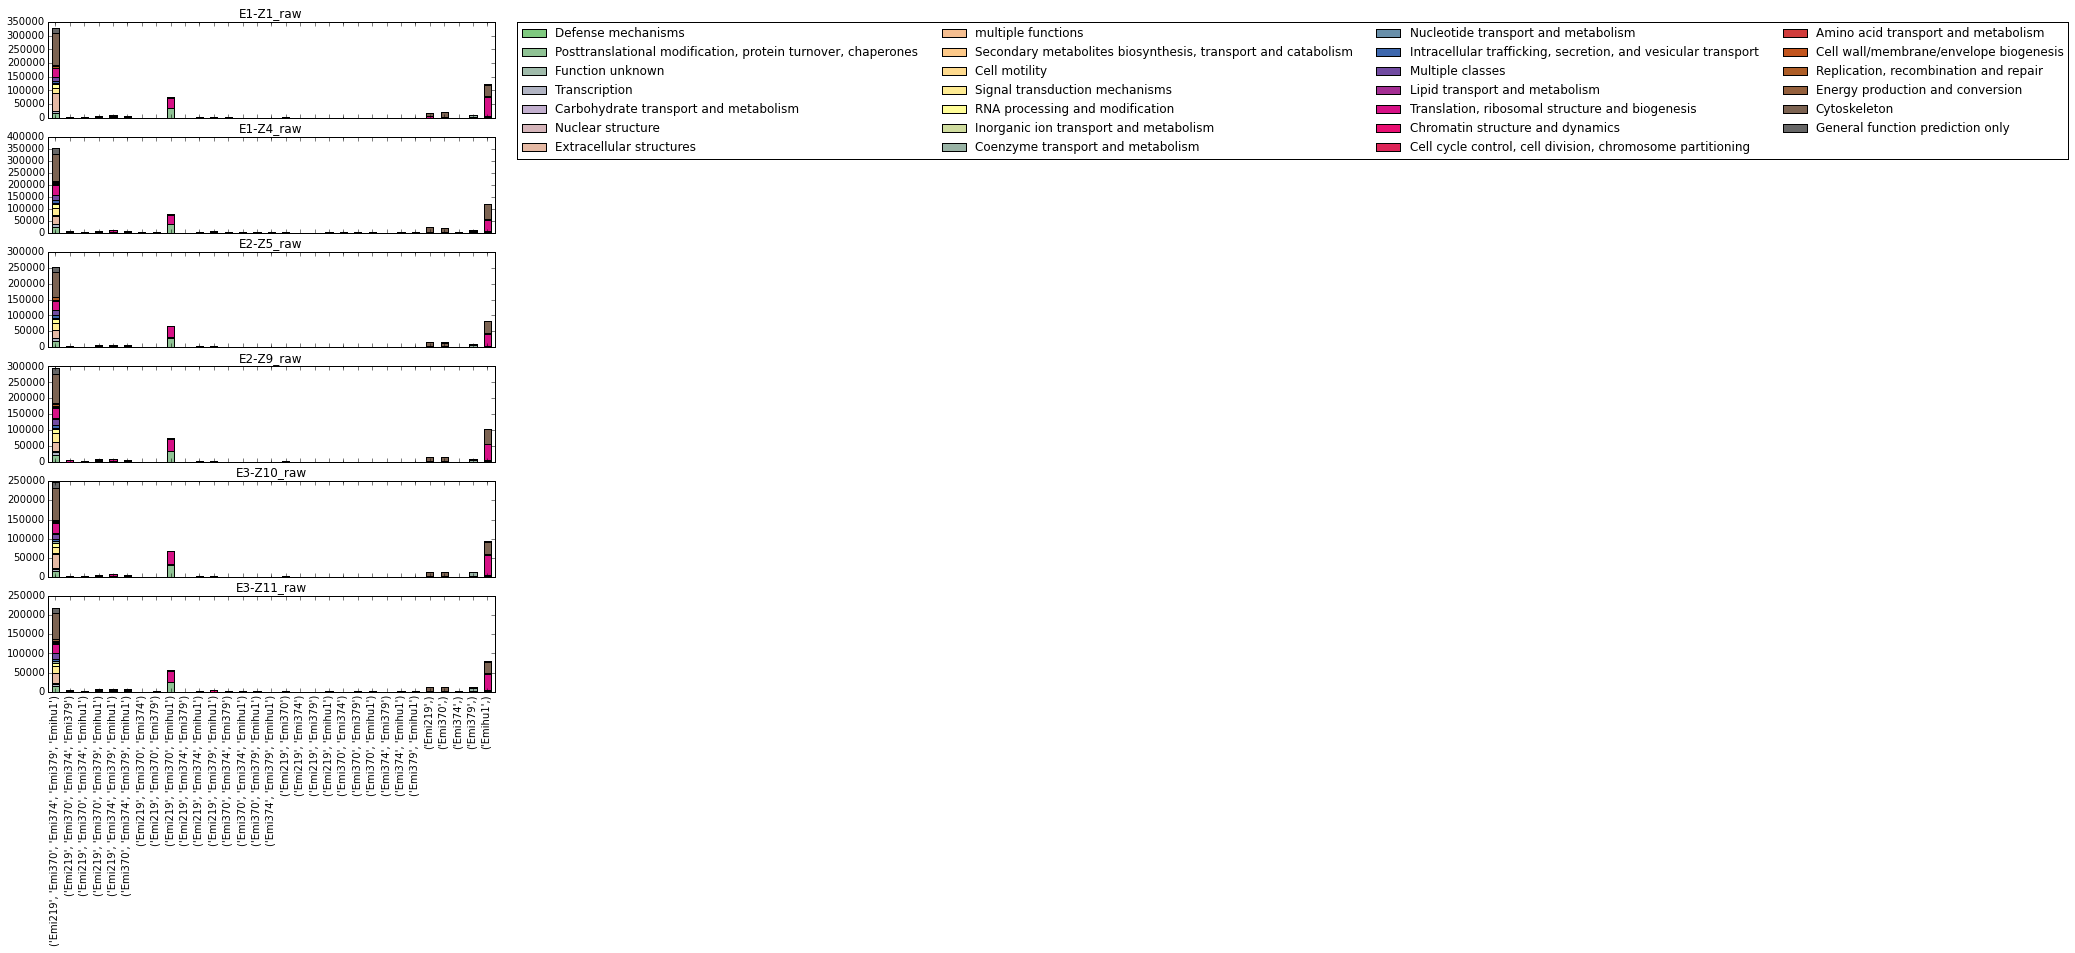

In [18]:
keys=KOG_TPM_Hash.keys()
rawKeys = [s for s in keys if "raw" in s]
InsituKeys = [s for s in rawKeys if "Z" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KOG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax, grid=False)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KOG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Raw_Insitu_KOG.pdf')

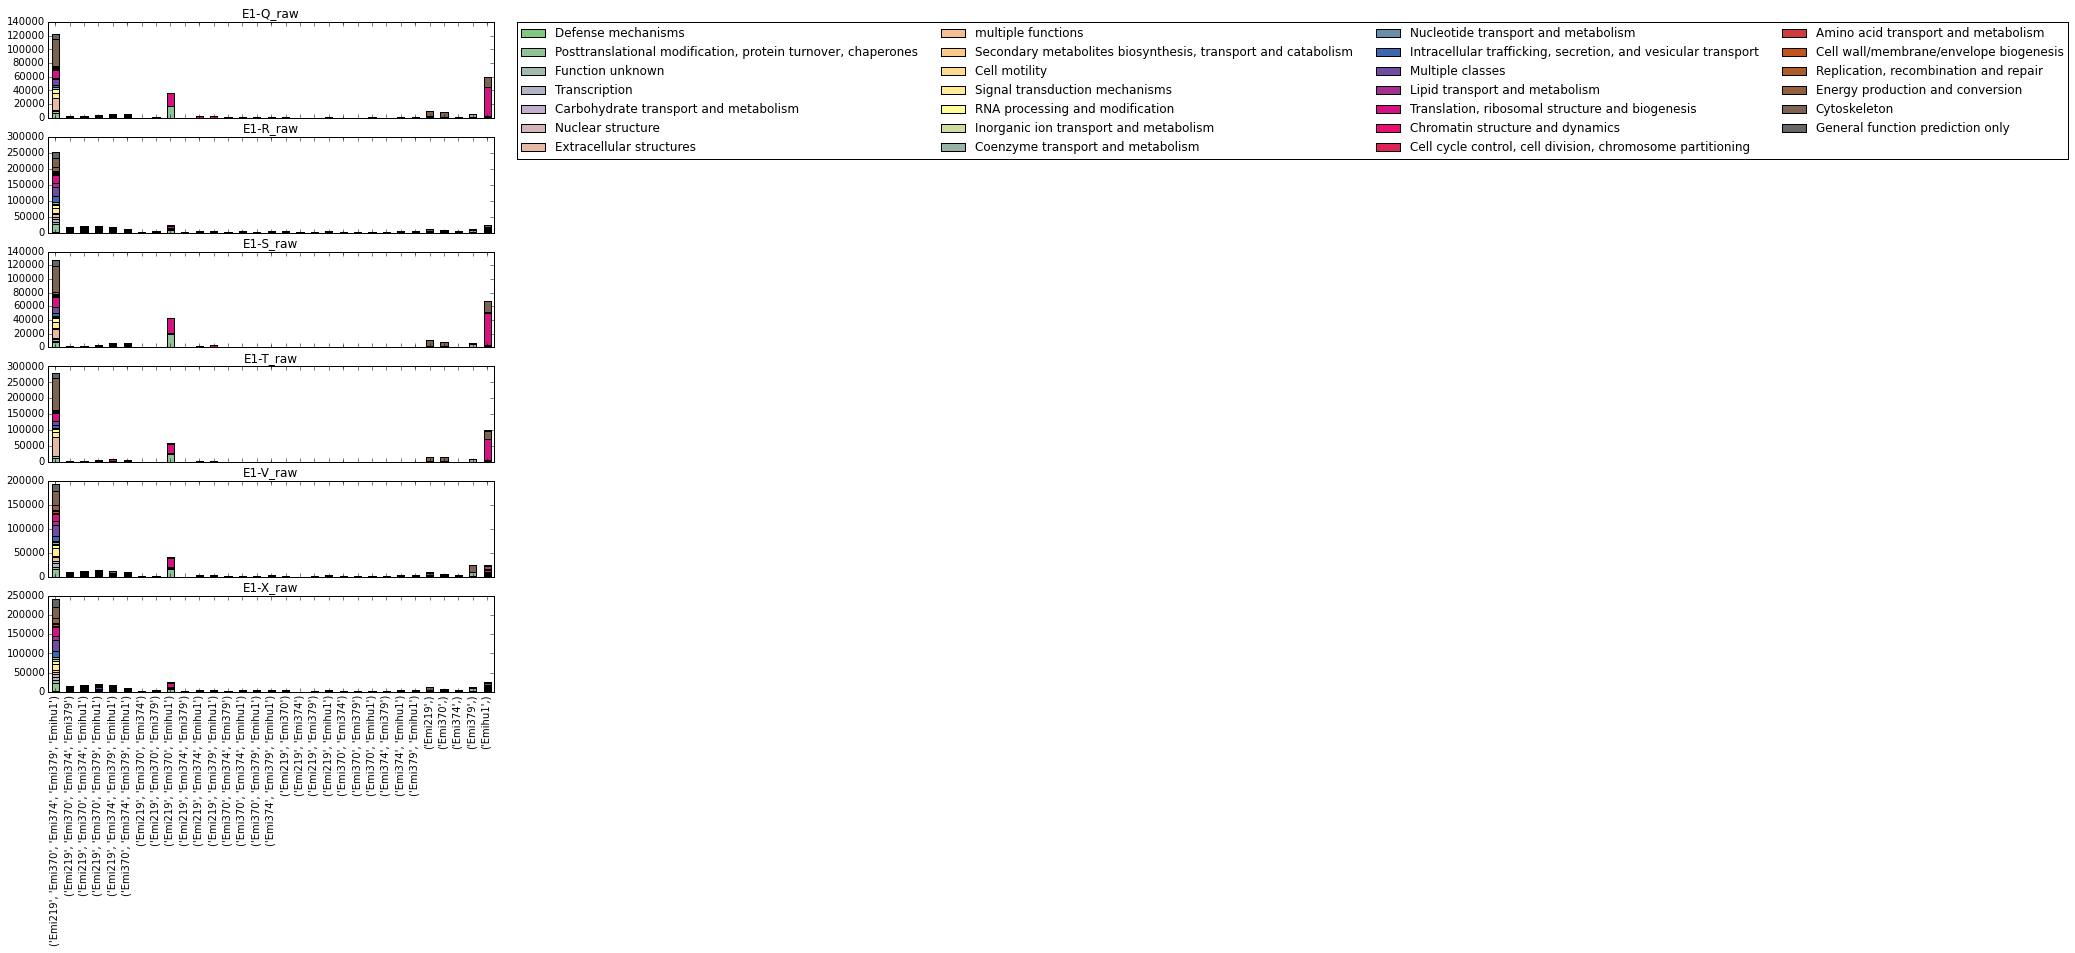

In [19]:
keys=KOG_TPM_Hash.keys()
rawKeys = [s for s in keys if "raw" in s]
InsituKeys = [s for s in rawKeys if "1" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KOG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax, grid=False)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KOG_TPM_Hash[keys].drop('Unannotated').T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Raw_E1_KOG.pdf')

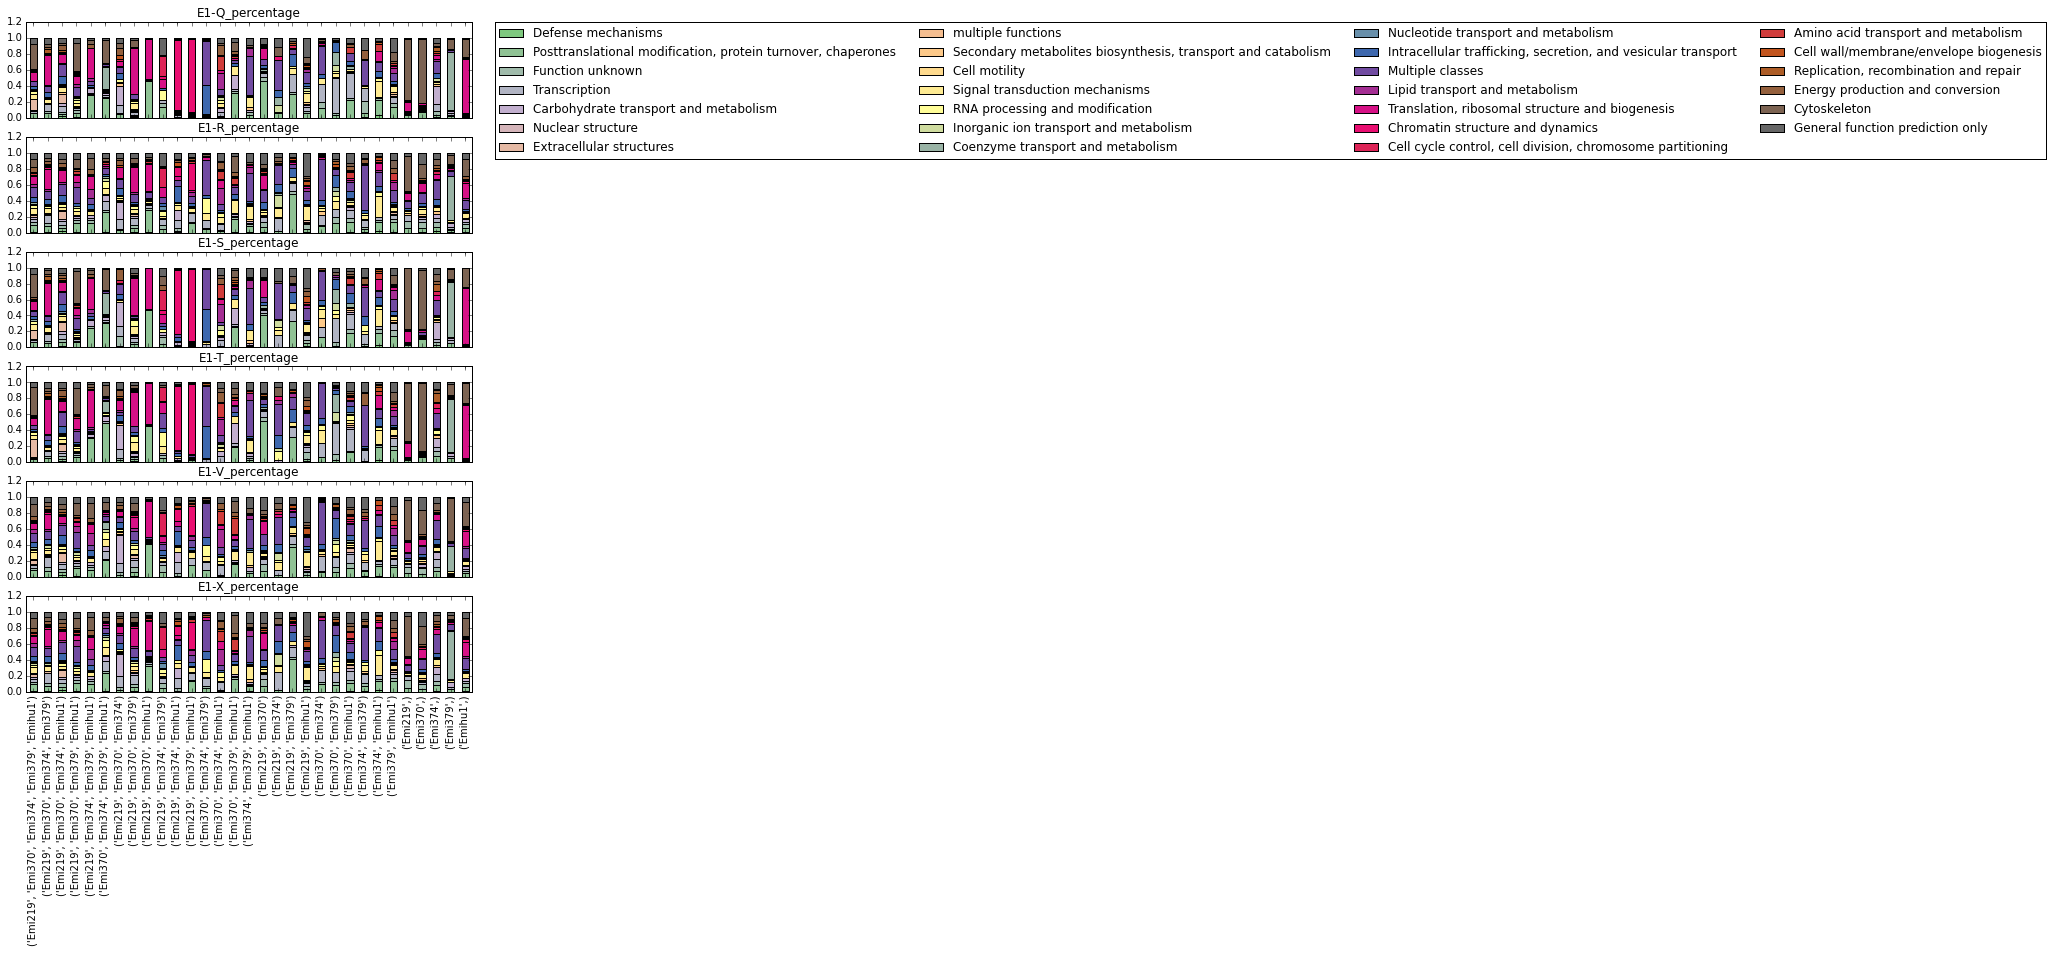

In [21]:
keys=KOG_TPM_Hash.keys()
rawKeys = [s for s in keys if "percentage" in s]
InsituKeys = [s for s in rawKeys if "1" in s]
InsituKeys=sorted(InsituKeys)

fig,axs=plt.subplots(6)
fig.set_figheight(12)
fig.set_figwidth(8)
c=0
for keys,ax in zip(InsituKeys,axs):
    c+=1
    if c==1:
        k=KOG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax, grid=False)
        k.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=4)

    else: 
        KOG_TPM_Hash[keys].T.plot(kind='bar', cmap=ccmap, stacked=True, title=keys,ax=ax,grid=False, legend=False)
fig.savefig('Percentage_E1_KOG.pdf')

In [56]:


rawKeys = [s for s in keys if "raw" in s]
rawKeys=sorted(rawKeys)
Ehux_Summed_TPM_KOG=pd.DataFrame(columns=rawKeys, index=KOG_TPM_Hash['E1-Q_raw'].index)

for key in rawKeys:
    v=KOG_TPM_Hash[key].sum(axis=1)
    Ehux_Summed_TPM_KOG[key]=v

Ehux_Summed_TPM_KOG=Ehux_Summed_TPM_KOG.drop('Unannotated')
Ehux_Summed_Percentage_KOG=Ehux_Summed_TPM_KOG/Ehux_Summed_TPM_KOG.sum()

def HeatMap(All_insitu_Percent, columns=None,colormap=b2m.sequential.YlOrRd_9.get_mpl_colormap(),m=1e-5):
    if columns:
        All_insitu_Percent=All_insitu_Percent[columns]
    # sckos=['SS1','SS2','SS3', 'SS4', 'SS5']
    All_insitu_Percent['mean']=All_insitu_Percent.mean(skipna=1, axis=1) #calculate mean value for each class

    All_insitu_Percent=All_insitu_Percent.sort(columns='mean', ascending=False)#Sort by the mean value

    All_insitu_Percent=All_insitu_Percent.drop('mean',1) #drop mean column
    All_insitu_Percent=All_insitu_Percent.loc[All_insitu_Percent.sum(axis=1)!=0]
    col_labels=list(All_insitu_Percent.index)
    row_labels=list(All_insitu_Percent.columns.values)
    fig3,ax3=plt.subplots()
    fig3.set_figheight(len(col_labels)/3)
    fig3.set_figwidth(len(row_labels))
    heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=colormap, norm=LogNorm(vmin=m, vmax=All_insitu_Percent.max().max()))
    #heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=plt.cm.jet, vmin=0, vmax=.25)
    ax3.set_xticks(np.arange(All_insitu_Percent.shape[1])+0.5, minor=False)
    ax3.set_yticks(np.arange(All_insitu_Percent.shape[0])+0.5, minor=False)
    ax3.invert_yaxis()
    ax3.xaxis.tick_top()
    ax3.margins(0,0)

    ax3.set_xticklabels(row_labels, minor=False)
    ax3.set_yticklabels(col_labels, minor=False)
    plt.colorbar(heatmap3)
    plt.show()
    return fig3
rawKeys = [s for s in keys if "raw" in s]
insituKeys = [s for s in rawKeys if "Z" in s]
insituKeys=sorted(insituKeys)
EKeys = [s for s in rawKeys if "E2" in s]
EKeys=sorted(EKeys)
E1Keys = [s for s in rawKeys if "E1" in s]
E1Keys=sorted(E1Keys)

# Insitu_HeatMap=HeatMap(Ehux_Summed_Percentage_KOG, columns=insituKeys)
# E2_Heatmap=HeatMap(Ehux_Summed_Percentage_KOG, columns=EKeys)
# E1_Heatmap=HeatMap(Ehux_Summed_Percentage_KOG, columns=E1Keys)
# Insitu_HeatMap.savefig('Insitu_KOGG_Heatmap.pdf')
# E1_Heatmap.savefig('E1_Heatmap_KOGG.pdf')
# E2_Heatmap.savefig('E2_Heatmap_KOGG.pdf')

# HeatMap(KOG_TPM_Hash['E1-R_percentage'])

/Users/harrietalexander/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrietalexander/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


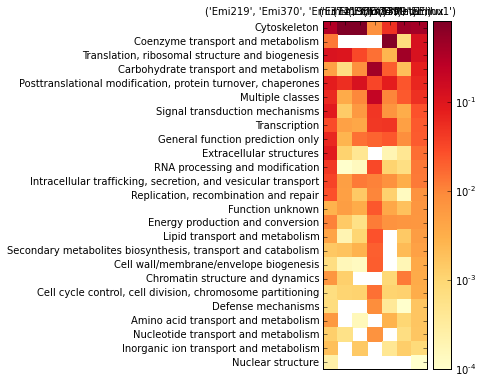

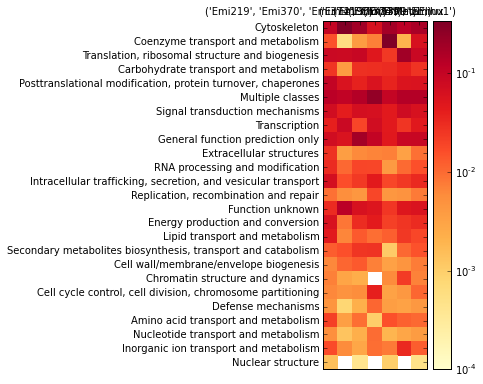

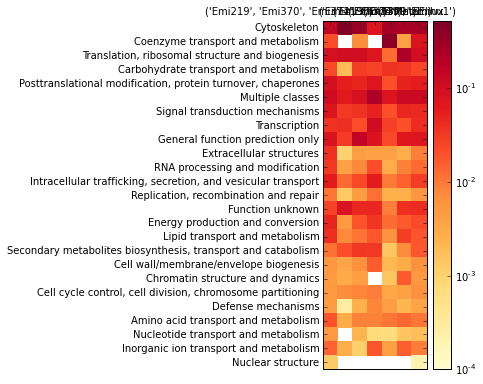

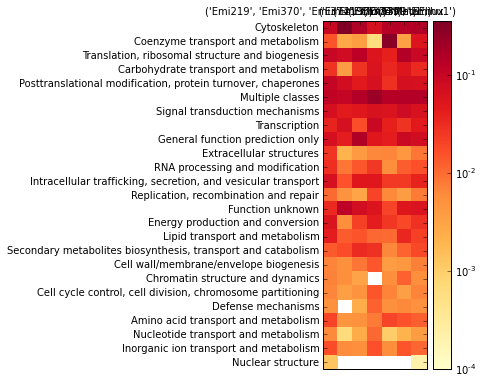

In [13]:
def HeatMap_KOGG_Strain(All_insitu_Percent, columns=None,colormap=b2m.sequential.YlOrRd_9.get_mpl_colormap(),m=1e-5, rowOrder=None):
    if columns:
        All_insitu_Percent=All_insitu_Percent[columns]
    # sckos=['SS1','SS2','SS3', 'SS4', 'SS5']

#     All_insitu_Percent['mean']=All_insitu_Percent.mean(skipna=1, axis=1) #calculate mean value for each class
    All_insitu_Percent['MetaEhux']= All_insitu_Percent.sum(axis=1)
    All_insitu_Percent['MetaEhux']=All_insitu_Percent['MetaEhux']/All_insitu_Percent['MetaEhux'].sum()
    newOrder=['MetaEhux']+columns
    All_insitu_Percent=All_insitu_Percent.sort(columns='MetaEhux', ascending=False)#Sort by the mean value
    if rowOrder==None:
        All_insitu_Percent=All_insitu_Percent.sort(columns='MetaEhux', ascending=False)#Sort by the mean value
    else:     
        All_insitu_Percent=All_insitu_Percent.loc[rowOrder]
#     All_insitu_Percent=All_insitu_Percent.drop('mean',1) #drop mean column
    All_insitu_Percent=All_insitu_Percent.loc[All_insitu_Percent.sum(axis=1)!=0]
    col_labels=list(All_insitu_Percent.index)
    row_labels=list(All_insitu_Percent.columns.values)
    fig3,ax3=plt.subplots()
    fig3.set_figheight(float(len(col_labels))/4)
    fig3.set_figwidth(float(len(row_labels))/3)
    heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=colormap, norm=LogNorm(vmin=m, vmax=All_insitu_Percent.max().max()))
    #heatmap3 = ax3.pcolor(All_insitu_Percent, cmap=plt.cm.jet, vmin=0, vmax=.25)
    ax3.set_xticks(np.arange(All_insitu_Percent.shape[1])+0.5, minor=False)
    ax3.set_yticks(np.arange(All_insitu_Percent.shape[0])+0.5, minor=False)
    ax3.invert_yaxis()
    ax3.xaxis.tick_top()
    ax3.margins(0,0)

    ax3.set_xticklabels(row_labels, minor=False)
    ax3.set_yticklabels(col_labels, minor=False)
    plt.colorbar(heatmap3)
    plt.show()
    return fig3,list(All_insitu_Percent.index), All_insitu_Percent

cols=KEGG_TPM_Hash['E1-Q_percentage'].columns

a=[s for s in cols if (len(s)==11)|(len(s)==50)]

fig,h, E2Z5=HeatMap_KOGG_Strain(KOG_TPM_Hash['E2-Z5_percentage'], a, m=1e-4)
fig2,j, E2R=HeatMap_KOGG_Strain(KOG_TPM_Hash['E2-R_percentage'], a, m=1e-4, rowOrder=h)
fig3,j, E2V=HeatMap_KOGG_Strain(KOG_TPM_Hash['E2-V_percentage'], a, m=1e-4, rowOrder=h)
fig4,j, E2X=HeatMap_KOGG_Strain(KOG_TPM_Hash['E2-X_percentage'], a, m=1e-4, rowOrder=h)

fig.savefig('E2_Z_KOG_Heatmap.pdf')
fig2.savefig('E2_R_KOG_Heatmap.pdf')
fig3.savefig('E2_V_KOG_Heatmap.pdf')
fig4.savefig('E2_X_KOG_Heatmap.pdf')

In [14]:
import numpy, scipy
import scipy.cluster.hierarchy as hier
import scipy.spatial.distance as dist

distMatrix=dist.pdist(E2R.T)
distSqMatrix = dist.squareform(distMatrix)
linkageMatrix=hier.linkage(distSqMatrix)

In [16]:
def KOGG_Strain_dendrogram(All_insitu_Percent, columns=None,colormap=b2m.sequential.YlOrRd_9.get_mpl_colormap(),m=1e-5, rowOrder=None):
    if columns:
        All_insitu_Percent=All_insitu_Percent[columns]
    # sckos=['SS1','SS2','SS3', 'SS4', 'SS5']

#     All_insitu_Percent['mean']=All_insitu_Percent.mean(skipna=1, axis=1) #calculate mean value for each class
    All_insitu_Percent['MetaEhux']= All_insitu_Percent.sum(axis=1)
    All_insitu_Percent['MetaEhux']=All_insitu_Percent['MetaEhux']/All_insitu_Percent['MetaEhux'].sum()
    All_insitu_Percent=All_insitu_Percent.loc[All_insitu_Percent.sum(axis=1)!=0]
    return All_insitu_Percent


In [17]:
linkage_KOG_DF=pd.DataFrame(index=KOG_TPM_Hash['E2-Q_percentage'].index)
for key in KOG_TPM_Hash:
    if 'percentage' in key:
        if 'E3' in key:
            pass
        else:
            KDF=KOGG_Strain_dendrogram(KOG_TPM_Hash[key])
            KDF=KDF[a]
            nameDict={}
            for cols in KDF.columns:
                if cols in a:
                    if cols=="('Emi219', 'Emi370', 'Emi374', 'Emi379', 'Emihu1')":
                        c='Core'
                    else:
                        c=cols
                    newCol=c+'_'+key.split('_')[0]
                    nameDict[cols]=newCol 
                    
            KDF.rename(columns=nameDict, inplace=True)
            linkage_KOG_DF=linkage_KOG_DF.join(KDF)

In [19]:
linkage_KOG_DF=linkage_KOG_DF.dropna()

{'color_list': ['g', 'g', 'g', 'g', 'g', 'b'],
 'dcoord': [[0.0, 0.19918813502314348, 0.19918813502314348, 0.0],
  [0.0, 0.20059091015148897, 0.20059091015148897, 0.19918813502314348],
  [0.0, 0.21963731249414356, 0.21963731249414356, 0.20059091015148897],
  [0.0, 0.25337183844357231, 0.25337183844357231, 0.21963731249414356],
  [0.0, 0.37259472590856041, 0.37259472590856041, 0.25337183844357231],
  [0.0, 0.61174689202021271, 0.61174689202021271, 0.37259472590856041]],
 'icoord': [[55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [25.0, 25.0, 43.75, 43.75],
  [15.0, 15.0, 34.375, 34.375],
  [5.0, 5.0, 24.6875, 24.6875]],
 'ivl': ['4', '1', '3', '5', '2', '0', '6'],
 'leaves': [4, 1, 3, 5, 2, 0, 6]}

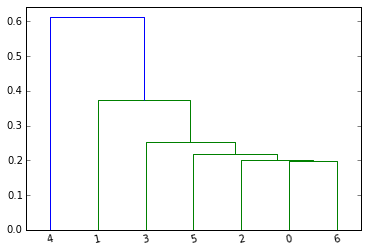

In [27]:
import numpy, scipy
import scipy.cluster.hierarchy as hier
import scipy.spatial.distance as dist
def CreateDendrogram(inDF):
    distMatrix=dist.pdist(inDF.T, 'correlation' )
    distSqMatrix = dist.squareform(distMatrix)
    linkageMatrix=hier.linkage(distSqMatrix) 
    dendro = hier.dendrogram(linkageMatrix)

    #get the order of rows according to the dendrogram 
    leaves = dendro['leaves'] 
    dendro=hier.dendrogram(linkageMatrix, labels=inDF.columns[leaves])
    print dendro.keys()

    D=CreateDendrogram(linkage_KOG_DF)
    
dendro=hier.dendrogram(linkageMatrix,)
dendro

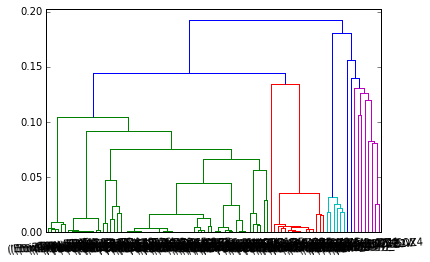

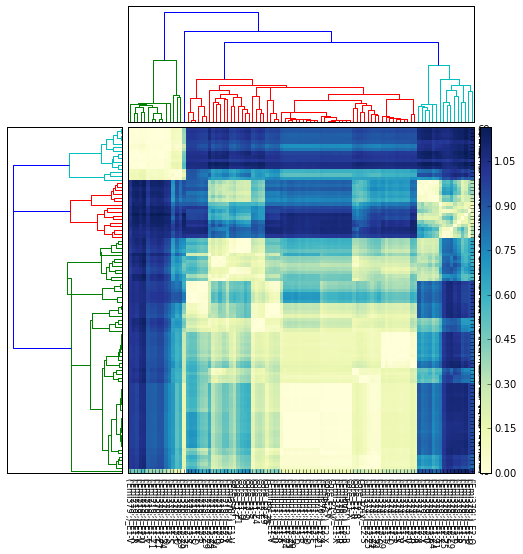

In [31]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
import matplotlib.pylab as pylab
def CreateDendrogram(inDF):
    distMatrix=dist.pdist(inDF.T, 'correlation')
    distSqMatrix = dist.squareform(distMatrix)
    linkageMatrix=hier.linkage(distMatrix) 
    dendro = hier.dendrogram(linkageMatrix)

    #get the order of rows according to the dendrogram 
    leaves = dendro['leaves'] 
    dendro=hier.dendrogram(linkageMatrix, labels=inDF.columns[leaves])
# Generate random features and distance matrix.
#     x = scipy.rand(40)
#     D = scipy.zeros([40,40])
#     for i in range(40):
#         for j in range(40):
#             D[i,j] = abs(x[i] - x[j])

    D=distSqMatrix
    # Compute and plot first dendrogram.
    fig = pylab.figure(figsize=(8,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    Y = sch.linkage(D, method='centroid')
    Z1 = sch.dendrogram(Y, orientation='right')
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Compute and plot second dendrogram.
    ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
    Y = sch.linkage(D, method='single')
    Z2 = sch.dendrogram(Y)
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
#     axmatrix.set_xticks([])
#     axmatrix.set_yticks([])

    # Plot colorbar.
    axmatrix.set_xticks(range(len(inDF.T.index)))
    axmatrix.set_xticklabels(inDF.columns[idx1], minor=False)
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    pylab.xticks(rotation=-90, fontsize=8)

    axmatrix.set_yticks(range(len(inDF.T.index)))
    axmatrix.set_yticklabels(idx2, minor=False)
    axmatrix.yaxis.set_label_position('right')
    axmatrix.yaxis.tick_right()

    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    fig.show()
    fig.savefig('/Users/harrietalexander/Dropbox (MIT)/dendrogram.pdf')


CreateDendrogram(linkage_KOG_DF)

AttributeError: 'module' object has no attribute 'stats'